In [1]:
# Import required packages
import time
import numpy as np
import pandas as pd
from tabulate import tabulate
import torch
from tqdm import trange
from pafik.solver import Solver
from pafik.settings import (
    DEFAULT_NSF,
    DEFULT_SOLVER,
)

In [2]:
import os
from datetime import datetime

WORKDIR = "/home/luca/pafik"

record_dir = f"{WORKDIR}/record/{datetime.today().strftime('%Y_%m_%d')}"
os.makedirs(record_dir, exist_ok=True)

solver_param = DEFULT_SOLVER
solver_param.workdir = WORKDIR
solver = Solver(solver_param=solver_param)

num_seeds = 2000
num_sols = num_seeds
num_poses = 1000
base_stds = np.arange(0.1, 1.5, 0.1)  # start, stop, step

WorldModel::LoadRobot: /home/luca/.cache/jrl/temp_urdfs/panda_arm_hand_formatted_link_filepaths_absolute.urdf
joint mimic: no multiplier, using default value of 1 
joint mimic: no offset, using default value of 0 
URDFParser: Link size: 17
URDFParser: Joint size: 12
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link0.dae (59388 verts, 20478 tris)
ManagedGeometry: loaded /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link0.dae in time 0.258846s
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link1.dae (37309 verts, 12516 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link2.dae (37892 verts, 12716 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jrl/urdfs/panda/meshes/visual/link3.dae (42512 verts, 14233 tris)
LoadAssimp: Loaded model /home/luca/m

In [3]:
def get_numerical_ik_sols(target_pose, num_seeds):
    seeds, _ = solver._robot.sample_joint_angles_and_poses(
        n=num_seeds, return_torch=False
    )
    numer_ik = np.empty((num_seeds, solver.n))
    for i in range(num_seeds):
        numer_ik[i] = solver.robot.inverse_kinematics_klampt(
            pose=target_pose, seed=seeds[i]
        )
    return numer_ik


_, P = solver._robot.sample_joint_angles_and_poses(n=num_poses, return_torch=False)

J_ground_truth = np.empty((num_poses, num_sols, solver.n))
for i in trange(num_poses):
    J_ground_truth[i] = get_numerical_ik_sols(P[i], num_seeds)
    
# Save to repeat the same experiment on NODEIK
np.save(f"{record_dir}/numerical_ik_sols.npy", J_ground_truth)
np.save(f"{record_dir}/poses.npy", P)

100%|██████████| 1000/1000 [22:32<00:00,  1.35s/it]


In [4]:
from mmd_helper import mmd_evaluate_multiple_poses

l2_mean = np.empty((len(base_stds)))
ang_mean = np.empty((len(base_stds)))
mmd_mean = np.empty((len(base_stds)))
J_hat_pafik = np.empty((len(base_stds), num_poses, num_sols, solver.n))

for i, std in enumerate(base_stds):
    solver.base_std = std
    P_expand_dim = np.repeat(np.expand_dims(P, axis=1), num_sols, axis=1).reshape(
        -1, P.shape[-1]
    )

    F = solver.F[
        solver.P_knn.kneighbors(
            np.atleast_2d(P), n_neighbors=num_sols, return_distance=False
        ).flatten()
    ]
    J_hat = solver.solve_batch(P_expand_dim, F, 1)
    l2, ang = solver.evaluate_pose_error_J3d_P2d(J_hat, P_expand_dim, return_all=True)
    J_hat = J_hat.reshape(num_poses, num_sols, -1)
    J_hat_pafik[i] = J_hat
    l2_mean[i] = l2.mean()
    ang_mean[i] = ang.mean()
    mmd_mean[i] = mmd_evaluate_multiple_poses(
        J_hat, J_ground_truth, num_poses=num_poses
    )
    assert not np.isnan(mmd_mean[i])

np.save(f"{record_dir}/J_hat_pafik.npy", J_hat_pafik)
df_pafik = pd.DataFrame({"l2": l2_mean, "ang": ang_mean, "mmd": mmd_mean, "std": base_stds})
df_pafik.to_pickle(f"{record_dir}/pafik_posture_mmd_std.pkl")
df_pafik.describe()

100%|██████████| 500/500 [02:47<00:00,  2.99it/s]


,l2,ang,mmd,std
count,14.000000,14.000000,14.000000,14.00000
mean,0.007664,0.063326,0.121711,0.75000
std,0.007179,0.040411,0.030796,0.41833
min,0.003047,0.030340,0.096777,0.10000
25%,0.003364,0.034896,0.099588,0.42500
50%,0.004390,0.046811,0.106498,0.75000
75%,0.008136,0.075475,0.134737,1.07500
max,0.027494,0.163996,0.192353,1.40000


In [5]:
from ikflow.utils import set_seed
from ikflow.model_loading import get_ik_solver

set_seed()
# Build IKFlowSolver and set weights
ik_solver, _ = get_ik_solver("panda__full__lp191_5.25m")
l2_flow = np.empty((len(base_stds)))
ang_flow = np.empty((len(base_stds)))
mmd_flow = np.empty((len(base_stds)))
J_hat_ikflow = np.empty((len(base_stds), num_poses, num_sols, solver.n))

for i, std in enumerate(base_stds):
    J_flow = np.array(
        [ik_solver.solve(p, n=num_sols, latent_scale=std).cpu().numpy() for p in P]
    ) # (num_sols, num_poses, n)
    J_hat_ikflow[i] = J_flow
    l2, ang = solver.evaluate_pose_error_J3d_P2d(J_flow.transpose(1, 0, 2), P, return_all=True)
    l2_flow[i] = l2.mean()
    ang_flow[i] = ang.mean()
    mmd_flow[i] = mmd_evaluate_multiple_poses(
        J_flow, J_ground_truth, num_poses=num_poses
    )

np.save(f"{record_dir}/J_hat_ikflow.npy", J_hat_ikflow)
df_flow = pd.DataFrame(
    {"l2": l2_flow, "ang": ang_flow, "mmd": mmd_flow, "std": base_stds}
)
df_flow.to_pickle(f"{record_dir}/ikflow_posture_mmd_std.pkl")
df_flow.describe()

config.py: Using device 'cuda:0'
set_seed() - random int:  541
ndim_tot=7WorldModel::LoadRobot: /tmp/panda_arm_hand_formatted_link_filepaths_absolute.urdf
joint mimic: no multiplier, using default value of 1 
joint mimic: no offset, using default value of 0 
URDFParser: Link size: 17
URDFParser: Joint size: 12
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jkinpylib/urdfs/panda/meshes/visual/link0.dae (59388 verts, 20478 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jkinpylib/urdfs/panda/meshes/visual/link1.dae (37309 verts, 12516 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jkinpylib/urdfs/panda/meshes/visual/link2.dae (37892 verts, 12716 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jkinpylib/urdfs/panda/meshes/visual/link3.dae (42512 verts, 14233 tris)
LoadAssimp: Loaded model /home/luca/miniconda3/lib/python3.9/site-packages/jkinpylib/urdfs/panda/mes

,l2,ang,mmd,std
count,14.000000,14.000000,14.000000,14.00000
mean,0.007577,0.043649,0.394725,0.75000
std,0.002231,0.008840,0.440229,0.41833
min,0.005077,0.034963,0.116556,0.10000
25%,0.005806,0.036233,0.122463,0.42500
50%,0.006980,0.040605,0.186132,0.75000
75%,0.008921,0.049148,0.446915,1.07500
max,0.012070,0.061637,1.613053,1.40000


# Load mmd posture diversity and present
Note that before run the following code, you need to run
- conda activate nodeik
- python nodeik_experiments.py

to obtain `df_nodeik` data 

In [6]:
df_pafik = pd.read_pickle(f"{record_dir}/pafik_posture_mmd_std.pkl")
df_ikflow = pd.read_pickle(f"{record_dir}/ikflow_posture_mmd_std.pkl")
df_nodeik = pd.read_pickle(f"{record_dir}/nodeik_posture_mmd_std.pkl")

<AxesSubplot: title={'center': 'mmd vs. Base Std'}, xlabel='std'>

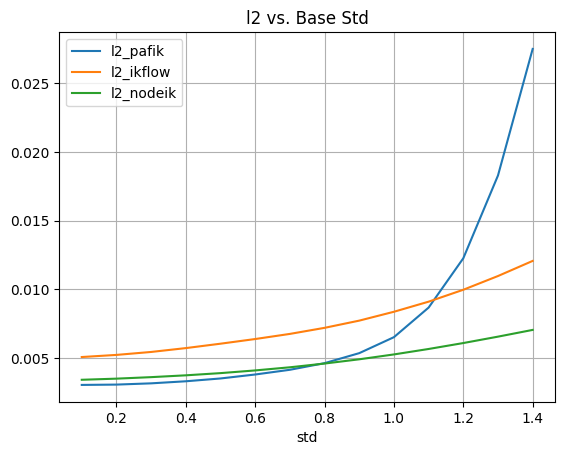

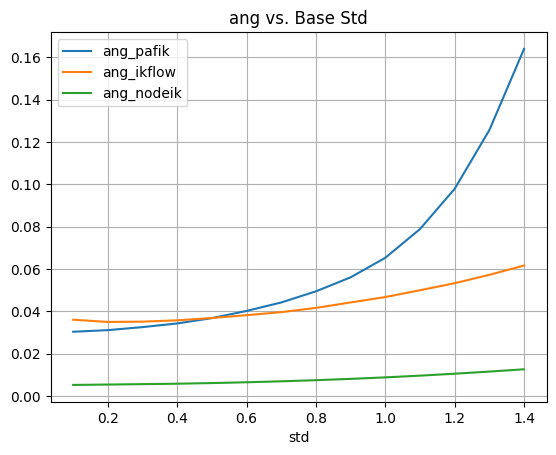

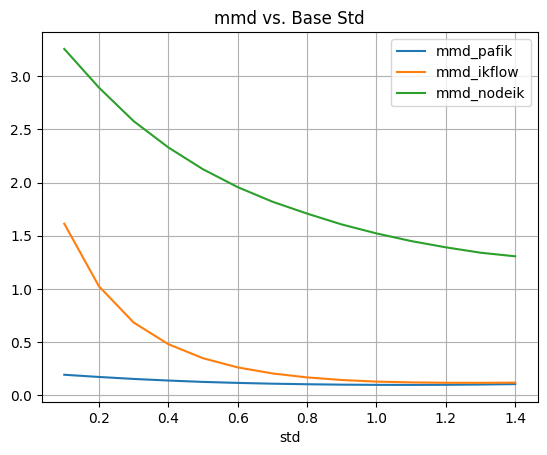

In [7]:
df = pd.DataFrame({
    "l2_pafik": df_pafik.l2.values,
    "ang_pafik": df_pafik.ang.values,
    "mmd_pafik": df_pafik.mmd.values,
    
    "l2_ikflow": df_ikflow.l2.values,
    "ang_ikflow": df_ikflow.ang.values,
    "mmd_ikflow": df_ikflow.mmd.values,
    
    "l2_nodeik": df_nodeik.l2.values,
    "ang_nodeik": df_nodeik.ang.values,
    "mmd_nodeik": df_nodeik.mmd.values,
    
    "std": base_stds
})

df.to_pickle(f"{record_dir}/three_methods_posture_mmd_std.pkl")
df.plot(x="std", y=["l2_pafik", "l2_ikflow", "l2_nodeik"], title="l2 vs. Base Std", grid=True)
df.plot(x="std", y=["ang_pafik", "ang_ikflow", "ang_nodeik"], title="ang vs. Base Std", grid=True)
df.plot(x="std", y=["mmd_pafik", "mmd_ikflow", "mmd_nodeik"], title="mmd vs. Base Std", grid=True)
